# Project goals
here, the goal is to create a program than can solve the sythetic inverse problem of a cloth. We will run the forward simulation of the cloth and capture ground truth data in warp, and then try to solve the inverse problem by running an optimization loop in order to tune parameters.

## 1. forward simulation: doing a forward cloth simulation

In [30]:
import warp as wp
wp.init()
print("devices: ", wp.get_devices())

devices:  ['cpu']


In [31]:
import warp as wp, math, numpy as np

### 1.1 setting up simulation and cloth

Simulation parameters. 

DT is the discrete time between simulation updates (in the physics world (used for accumulation with the euler method), not how long it takes to do the computation) at 240Hz or 1/240 ms or 4.17 ms. so step 1 happens at 0ms, then step 2 at 4ms, ...

STEPS is how many of the steps should be computed overall in the simulation, computed every DT seconds, which also determines the simulation run time. i.e. how many snapshots are you making.

Need to make a tradeoff between these 2. Higher DT gives more accurate physics, but then I have to double my steps to get the same simulation time which makes a quadratic connection.

In [86]:
#cloth data
W, H = 20, 20 #grid size; makes 400 particles to work with
SPACE_DELTA = 0.05 #space between particles -> defines distance between particles and affects the detail
MASS = 0.02 #per particle in kg

# spring system
K = 200.0 #spring constant; higher = siffer and less strechy cloth
C = 0.001 #damping coefficient. higher values make it less bouncy

#sim control
DT = 1.0 / 240.0
STEPS = 1200

# env
G = 9.81

#config
USE_DIAGONALS = True #use diagonal springs on top of connecting like a grid (so 8 neighbors instead of 4)
DEVICE = wp.get_device()


In [33]:
def make_grid_positions(w, h, dx):
    x = np.zeros(((w*h), 2), dtype=np.float32)
    for j in range(h):
        for i in range(w):
            #note that we are centering from bottom-left here
            idx = j*w+i
            x[idx, 0] = i*dx
            x[idx, 1] = j*dx

    return x

In [34]:
make_grid_positions(W, H, SPACE_DELTA)

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       [0.15, 0.  ],
       [0.2 , 0.  ],
       [0.25, 0.  ],
       [0.3 , 0.  ],
       [0.35, 0.  ],
       [0.4 , 0.  ],
       [0.45, 0.  ],
       [0.5 , 0.  ],
       [0.55, 0.  ],
       [0.6 , 0.  ],
       [0.65, 0.  ],
       [0.7 , 0.  ],
       [0.75, 0.  ],
       [0.8 , 0.  ],
       [0.85, 0.  ],
       [0.9 , 0.  ],
       [0.95, 0.  ],
       [0.  , 0.05],
       [0.05, 0.05],
       [0.1 , 0.05],
       [0.15, 0.05],
       [0.2 , 0.05],
       [0.25, 0.05],
       [0.3 , 0.05],
       [0.35, 0.05],
       [0.4 , 0.05],
       [0.45, 0.05],
       [0.5 , 0.05],
       [0.55, 0.05],
       [0.6 , 0.05],
       [0.65, 0.05],
       [0.7 , 0.05],
       [0.75, 0.05],
       [0.8 , 0.05],
       [0.85, 0.05],
       [0.9 , 0.05],
       [0.95, 0.05],
       [0.  , 0.1 ],
       [0.05, 0.1 ],
       [0.1 , 0.1 ],
       [0.15, 0.1 ],
       [0.2 , 0.1 ],
       [0.25, 0.1 ],
       [0.3 , 0.1 ],
       [0.35,

In [35]:
edges = []
for j in range(H):
    for i in range(W):
        if i+1 < W: edges.append((j*W+i, j*W+(i+1)))
        if j+1 < H: edges.append((j*W+i, (j+1)*W+i))
edges = np.array(edges, dtype=np.int32)
edges.shape
edges

array([[  0,   1],
       [  0,  20],
       [  1,   2],
       ...,
       [396, 397],
       [397, 398],
       [398, 399]], shape=(760, 2), dtype=int32)

In [36]:
pos = make_grid_positions(W, H, SPACE_DELTA)
pos[0]

array([0., 0.], dtype=float32)

In [37]:
pos[1]

array([0.05, 0.  ], dtype=float32)

In [38]:
pos[1] - pos[0]

array([0.05, 0.  ], dtype=float32)

In [39]:
def make_edges_and_rests(w, h, dx, diagonals=True):
    edges = []
    for j in range(h):
        for i in range(w):
            if i+1 < w: edges.append((j*w+i, j*w+(i+1)))
            if j+1 < h: edges.append((j*w+i, (j+1)*w+i))

    #create an array of all the edges, by storing each element as [node1, node2], where the node itself is stored as j*w+i
    edges = np.array(edges, dtype=np.int32)
    rest = np.zeros((edges.shape[0],), dtype=np.float32)
    pos = make_grid_positions(w, h, dx)

    for e, (a,b) in enumerate(edges):
        dir_vec = pos[b] - pos[a]
        rest[e] = np.linalg.norm(dir_vec)

    return edges, rest

In [40]:
edges, rests = make_edges_and_rests(W, H, SPACE_DELTA, False)
rests.shape

(760,)

In [41]:
make_edges_and_rests(W, H, SPACE_DELTA, False)

(array([[  0,   1],
        [  0,  20],
        [  1,   2],
        ...,
        [396, 397],
        [397, 398],
        [398, 399]], shape=(760, 2), dtype=int32),
 array([0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
        0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
        0.05000001, 0.05      , 0.04999998, 0.05      , 0.05000001,
        0.05      , 0.04999998, 0.05      , 0.05000001, 0.05      ,
        0.05000001, 0.05      , 0.05000001, 0.05      , 0.04999995,
        0.05      , 0.05000001, 0.05      , 0.05000001, 0.05      ,
        0.05000001, 0.05      , 0.05000001, 0.05      , 0.04999995,
        0.05      , 0.05000001, 0.05      , 0.05      , 0.05      ,
        0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
        0.05      , 0.05      , 0.05      , 0.05      , 0.05000001,
        0.05      , 0.04999998, 0.05      , 0.05000001, 0.05      ,
        0.04999998, 0.05      , 0.05000001, 0.05      , 0.05000001,
        0.05      , 

In [42]:
#if the particle is pinned, mark as 1, otherwise mark it as 0
def make_pins(w, h):
    pins = np.zeros((w*h,), dtype=wp.int32)
    pins[0] = 1
    pins[w-1] = 1
    return pins

### 1.2 warp kernels and calculations
Now that the functions for setting up the simulation and the cloth are setup, it is time make the simulations in warp

here, the warp kernel runs a bunch of times in parallel, but with different thread ids. in these functions, we are having each thread work on a 

In [43]:
@wp.kernel
def zero_vec2(a: wp.array(dtype=wp.vec2)):
    i = wp.tid()
    a[i] = wp.vec2(0.0, 0.0)

In [129]:
@wp.kernel
def spring_forces(pos: wp.array(dtype=wp.vec2),
                  edges: wp.array2d(dtype=wp.int32),
                  rest: wp.array(dtype=wp.float32),
                  k: float,
                  f: wp.array(dtype=wp.vec2)):
    #what edge and thread we are working with right now
    e = wp.tid()

    #get the indices of connected nodes that we are currently dealing with
    i = edges[e][0]
    j = edges[e][1]

    dir_vec = pos[i] - pos[j] #2d vector
    L = wp.length(dir_vec) + 1e-6 #to prevent div by 0
    dir_unit = dir_vec / L
    Fs = -k * (L - rest[e]) * dir_unit #k*delta_L as a scaled 2d vector
    wp.atomic_add(f, i, Fs)
    wp.atomic_add(f, j, -Fs) #netwons third law; the spring applied Fs to i, and j is connected to its other side so -Fs gets applied

In [45]:
@wp.kernel
def damping_forces(v: wp.array(dtype=wp.vec2),
                   c: float,
                   f: wp.array(dtype=wp.vec2)):
    i = wp.tid()
    wp.atomic_add(f, i, -c*v[i])

In [103]:
@wp.kernel
def integrate(pos: wp.array(dtype=wp.vec2),
              velocities: wp.array(dtype=wp.vec2),
              forces: wp.array(dtype=wp.vec2),
              masses: wp.array(dtype=float),
              pinned: wp.array(dtype=wp.int32),
              g: float,
              dt: float):

    i = wp.tid()

    if pinned[i] == 1:
        velocities[i] = wp.vec2(0.0, 0.0)
        return
    
    acceleration = forces[i] / masses[i] + wp.vec2(0.0, -g)

    # Using euler integration
    velocities[i] = velocities[i] + acceleration * dt
    pos[i] = pos[i] + velocities[i] * dt

Running the code, you make your arrays for the position, velocity, edges, and rest lengths

a quick implementation note is the difference between how velocity and forces are being instantiated, despite being structured the same (size: particlecount, 2d each holding x and y vector information). we make velocity with numpy, and then turn it into a wp array. this gives flexibility to also start with initial velocities if we want before making it a wp array. f is always zero, so we make it on the device instead if copying from host to avoid unneccessary overhead.

In [47]:
pos_np = make_grid_positions(W, H, SPACE_DELTA).astype(np.float32)
velcoity_np = np.zeros_like(pos_np)
edges_np, rest_np = make_edges_and_rests(W, H, SPACE_DELTA, False)
pins_np = make_pins(W, H)
masses_np = np.full(W*H, MASS)

pos = wp.array(pos_np, dtype=wp.vec2, device=DEVICE)
velocity = wp.array(velcoity_np, dtype=wp.vec2, device=DEVICE)
edges = wp.array(edges_np, dtype=wp.int32, device=DEVICE)
rest = wp.array(rest_np, dtype=wp.float32, device=DEVICE)
pins = wp.array(pins_np, dtype=wp.int32, device=DEVICE)
masses = wp.array(masses_np, dtype=float, device=DEVICE)
forces = wp.zeros(W*H, dtype=wp.vec2, device=DEVICE)

frames = []

for t in range(STEPS):
    wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
    wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(K), forces], device=DEVICE)
    wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(C), forces], device=DEVICE)
    wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(G), float(DT)], device=DEVICE)

    frames.append(pos)

In [48]:
traj = np.stack(frames)  # (frames, N, 2)
np.save("cloth_target.npy", traj)
print("Saved ground-truth to cloth_target.npy with shape", traj.shape)

Saved ground-truth to cloth_target.npy with shape (1200, 400, 2)


In [49]:
def setup_data():
    pos_np = make_grid_positions(W, H, SPACE_DELTA).astype(np.float32)
    velcoity_np = np.zeros_like(pos_np)
    edges_np, rest_np = make_edges_and_rests(W, H, SPACE_DELTA, False)
    pins_np = make_pins(W, H)
    masses_np = np.full(W*H, MASS)

    pos = wp.array(pos_np, dtype=wp.vec2, device=DEVICE)
    velocity = wp.array(velcoity_np, dtype=wp.vec2, device=DEVICE)
    edges = wp.array(edges_np, dtype=wp.int32, device=DEVICE)
    rest = wp.array(rest_np, dtype=wp.float32, device=DEVICE)
    pins = wp.array(pins_np, dtype=wp.int32, device=DEVICE)
    masses = wp.array(masses_np, dtype=float, device=DEVICE)
    forces = wp.zeros(W*H, dtype=wp.vec2, device=DEVICE)

    return pos, velocity, edges, rest, pins, masses, forces

In [50]:
def run_sim():
    pos, velocity, edges, rest, pins, masses, forces = setup_data()

    frames = []

    for t in range(STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
        wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(K), forces], device=DEVICE)
        wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(C), forces], device=DEVICE)
        wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(G), float(DT)], device=DEVICE)

        frames.append(pos)
    
    return frames

In [51]:
def save_sim(sim_frames):
    traj = np.stack(sim_frames)  # (frames, particle count, 2)
    np.save("cloth_target.npy", traj)
    print("Saved ground-truth to cloth_target.npy with shape", traj.shape)

### 1.3 tests

might be a good idea to plot the position a pin with x vs. t and y vs. t

In [52]:
pos, velocity, edges, rest, pins, masses, forces = setup_data()
print(f"{np.array(pos)}")

[[0.   0.  ]
 [0.05 0.  ]
 [0.1  0.  ]
 [0.15 0.  ]
 [0.2  0.  ]
 [0.25 0.  ]
 [0.3  0.  ]
 [0.35 0.  ]
 [0.4  0.  ]
 [0.45 0.  ]
 [0.5  0.  ]
 [0.55 0.  ]
 [0.6  0.  ]
 [0.65 0.  ]
 [0.7  0.  ]
 [0.75 0.  ]
 [0.8  0.  ]
 [0.85 0.  ]
 [0.9  0.  ]
 [0.95 0.  ]
 [0.   0.05]
 [0.05 0.05]
 [0.1  0.05]
 [0.15 0.05]
 [0.2  0.05]
 [0.25 0.05]
 [0.3  0.05]
 [0.35 0.05]
 [0.4  0.05]
 [0.45 0.05]
 [0.5  0.05]
 [0.55 0.05]
 [0.6  0.05]
 [0.65 0.05]
 [0.7  0.05]
 [0.75 0.05]
 [0.8  0.05]
 [0.85 0.05]
 [0.9  0.05]
 [0.95 0.05]
 [0.   0.1 ]
 [0.05 0.1 ]
 [0.1  0.1 ]
 [0.15 0.1 ]
 [0.2  0.1 ]
 [0.25 0.1 ]
 [0.3  0.1 ]
 [0.35 0.1 ]
 [0.4  0.1 ]
 [0.45 0.1 ]
 [0.5  0.1 ]
 [0.55 0.1 ]
 [0.6  0.1 ]
 [0.65 0.1 ]
 [0.7  0.1 ]
 [0.75 0.1 ]
 [0.8  0.1 ]
 [0.85 0.1 ]
 [0.9  0.1 ]
 [0.95 0.1 ]
 [0.   0.15]
 [0.05 0.15]
 [0.1  0.15]
 [0.15 0.15]
 [0.2  0.15]
 [0.25 0.15]
 [0.3  0.15]
 [0.35 0.15]
 [0.4  0.15]
 [0.45 0.15]
 [0.5  0.15]
 [0.55 0.15]
 [0.6  0.15]
 [0.65 0.15]
 [0.7  0.15]
 [0.75 0.15]
 [0.8  0.15]

Note: warp's .numpy() function only copies the data if the array is stored in the gpu. if it is already in cpu, only a reference gets passed. just wanted to make a note to avoid issues like this in future. this is also why i added the .copy() function

In [112]:
pos, velocity, edges, rest, pins, masses, forces = setup_data()
print(f"{np.array(pos)[5][0]}")

positions_plot = []

for t in range(STEPS):
    wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
    wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(K), forces], device=DEVICE)
    wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(C), forces], device=DEVICE)
    wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(G), float(DT)], device=DEVICE)

    pos_np = pos.numpy()
    positions_plot.append(pos_np.copy()) #had to do .copy() in case device is cpu, otherwise a reference would be passed each time
    #print(f"{np.array(pos_np)[5][0]}")

    print(f"Timestep {t}: pos_np[5] = {pos_np[5]}")
    
    # Check if the appended data is correct
    if t < 20:  # Just check first few timesteps
        print(f"  positions_plot[{t}][5] = {positions_plot[t][5]}")


0.25
Timestep 0: pos_np[5] = [ 2.5000000e-01 -1.7031252e-04]
  positions_plot[0][5] = [ 2.5000000e-01 -1.7031252e-04]
Timestep 1: pos_np[5] = [ 0.25      -0.0005109]
  positions_plot[1][5] = [ 0.25      -0.0005109]
Timestep 2: pos_np[5] = [ 0.25       -0.00102173]
  positions_plot[2][5] = [ 0.25       -0.00102173]
Timestep 3: pos_np[5] = [ 0.25       -0.00170277]
  positions_plot[3][5] = [ 0.25       -0.00170277]
Timestep 4: pos_np[5] = [ 0.25       -0.00255398]
  positions_plot[4][5] = [ 0.25       -0.00255398]
Timestep 5: pos_np[5] = [ 0.25       -0.00357532]
  positions_plot[5][5] = [ 0.25       -0.00357532]
Timestep 6: pos_np[5] = [ 0.25       -0.00476676]
  positions_plot[6][5] = [ 0.25       -0.00476676]
Timestep 7: pos_np[5] = [ 0.25       -0.00612827]
  positions_plot[7][5] = [ 0.25       -0.00612827]
Timestep 8: pos_np[5] = [ 0.24999997 -0.0076598 ]
  positions_plot[8][5] = [ 0.24999997 -0.0076598 ]
Timestep 9: pos_np[5] = [ 0.24999984 -0.00936133]
  positions_plot[9][5] = [ 0

In [113]:
# First, let's verify what we have in positions_plot right after the simulation
print("=== DEBUGGING positions_plot ===")
print("Type of positions_plot:", type(positions_plot))
print("Length of positions_plot:", len(positions_plot))
print("Type of first element:", type(positions_plot[0]))
print("Shape of first element:", positions_plot[0].shape)

# Check a few specific timesteps that we know should be different
print("\n=== CHECKING SPECIFIC TIMESTEPS ===")
print("Timestep 0, particle 5:", positions_plot[0][5])
print("Timestep 10, particle 5:", positions_plot[10][5])
print("Timestep 100, particle 5:", positions_plot[100][5])
print("Timestep 500, particle 5:", positions_plot[500][5])
print("Timestep 1199, particle 5:", positions_plot[1199][5])

# Now let's check what happens when we enumerate
print("\n=== CHECKING ENUMERATION ===")
for t, positions_at_t in enumerate(positions_plot):
    if t in [0, 10, 100, 500, 1199]:  # Only check specific timesteps
        print(f"Timestep {t}, particle 5: {positions_at_t[5]}")
    if t > 1200:  # Safety check
        break

=== DEBUGGING positions_plot ===
Type of positions_plot: <class 'list'>
Length of positions_plot: 1200
Type of first element: <class 'numpy.ndarray'>
Shape of first element: (400, 2)

=== CHECKING SPECIFIC TIMESTEPS ===
Timestep 0, particle 5: [ 2.5000000e-01 -1.7031252e-04]
Timestep 10, particle 5: [ 0.24999942 -0.01123282]
Timestep 100, particle 5: [ 0.21953368 -0.40669945]
Timestep 500, particle 5: [ 0.25252968 -0.41652447]
Timestep 1199, particle 5: [ 0.2881615  -0.29779893]

=== CHECKING ENUMERATION ===
Timestep 0, particle 5: [ 2.5000000e-01 -1.7031252e-04]
Timestep 10, particle 5: [ 0.24999942 -0.01123282]
Timestep 100, particle 5: [ 0.21953368 -0.40669945]
Timestep 500, particle 5: [ 0.25252968 -0.41652447]
Timestep 1199, particle 5: [ 0.2881615  -0.29779893]


In [ ]:
def debug_sim(k_debug, c_debug, dt_debug, g_debug):
    pos, velocity, edges, rest, pins, masses, forces = setup_data()
    print(f"{np.array(pos)[5][0]}")

    positions_plot = []

    for t in range(STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
        wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(k_debug), forces], device=DEVICE)
        wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(c_debug), forces], device=DEVICE)
        wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(g_debug), float(dt_debug)], device=DEVICE)

        pos_np = pos.numpy()
        positions_plot.append(pos_np.copy()) #had to do .copy() in case device is cpu, otherwise a reference would be passed each time
        #print(f"{np.array(pos_np)[5][0]}")

    return np.array(positions_plot)

In [114]:
pos_test = debug_sim(K, C, DT, G)
# First, let's verify what we have in positions_plot right after the simulation
print("=== DEBUGGING positions_plot ===")
print("Type of positions_plot:", type(positions_plot))
print("Length of positions_plot:", len(positions_plot))
print("Type of first element:", type(positions_plot[0]))
print("Shape of first element:", positions_plot[0].shape)

# Check a few specific timesteps that we know should be different
print("\n=== CHECKING SPECIFIC TIMESTEPS ===")
print("Timestep 0, particle 5:", positions_plot[0][5])
print("Timestep 10, particle 5:", positions_plot[10][5])
print("Timestep 100, particle 5:", positions_plot[100][5])
print("Timestep 500, particle 5:", positions_plot[500][5])
print("Timestep 1199, particle 5:", positions_plot[1199][5])

# Now let's check what happens when we enumerate
print("\n=== CHECKING ENUMERATION ===")
for t, positions_at_t in enumerate(positions_plot):
    if t in [0, 10, 100, 500, 1199]:  # Only check specific timesteps
        print(f"Timestep {t}, particle 5: {positions_at_t[5]}")
    if t > 1200:  # Safety check
        break

0.25
=== DEBUGGING positions_plot ===
Type of positions_plot: <class 'list'>
Length of positions_plot: 1200
Type of first element: <class 'numpy.ndarray'>
Shape of first element: (400, 2)

=== CHECKING SPECIFIC TIMESTEPS ===
Timestep 0, particle 5: [ 2.5000000e-01 -1.7031252e-04]
Timestep 10, particle 5: [ 0.24999942 -0.01123282]
Timestep 100, particle 5: [ 0.21953368 -0.40669945]
Timestep 500, particle 5: [ 0.25252968 -0.41652447]
Timestep 1199, particle 5: [ 0.2881615  -0.29779893]

=== CHECKING ENUMERATION ===
Timestep 0, particle 5: [ 2.5000000e-01 -1.7031252e-04]
Timestep 10, particle 5: [ 0.24999942 -0.01123282]
Timestep 100, particle 5: [ 0.21953368 -0.40669945]
Timestep 500, particle 5: [ 0.25252968 -0.41652447]
Timestep 1199, particle 5: [ 0.2881615  -0.29779893]


In [88]:
import matplotlib.pyplot as plt

In [89]:
positions_plot_array = np.array(positions_plot)

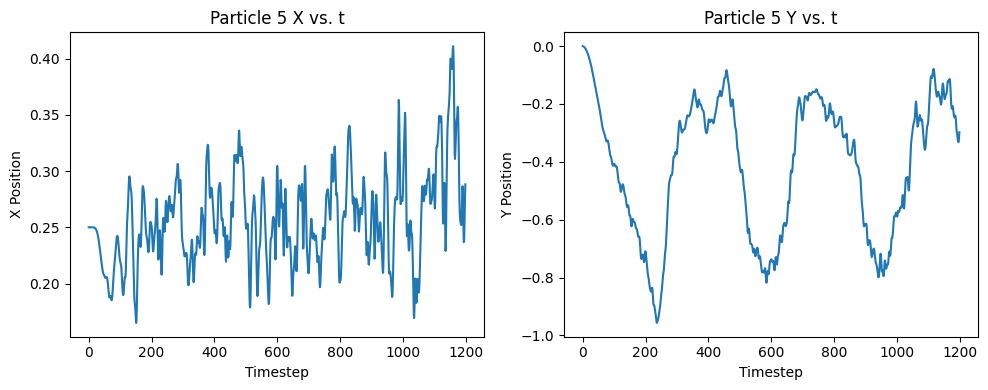

In [110]:
index = 5

timesteps = np.arange(STEPS)
x_vals = positions_plot_array[:, index, 0]
y_vals = positions_plot_array[:, index, 1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(timesteps, x_vals)
plt.title(f'Particle {index} X vs. t')
plt.xlabel('Timestep')
plt.ylabel('X Position')

plt.subplot(1, 2, 2)
plt.plot(timesteps, y_vals)
plt.title(f'Particle {index} Y vs. t')
plt.xlabel('Timestep')
plt.ylabel('Y Position')

plt.tight_layout()
plt.show()

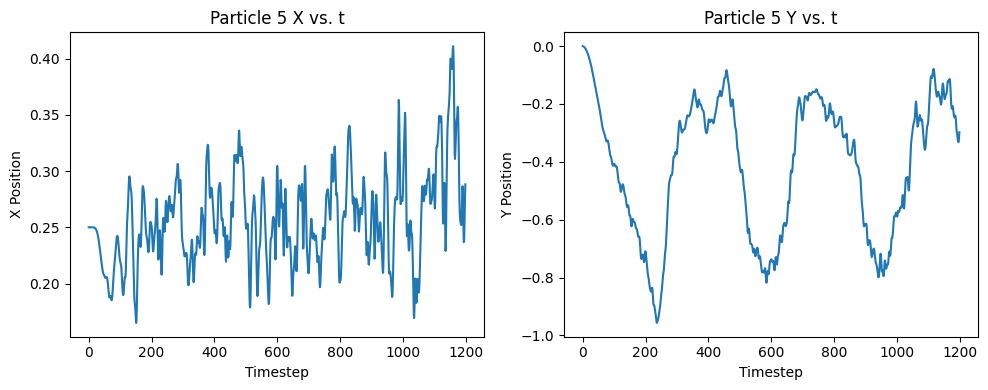

In [117]:
def plot_at_index_vs_time(index, pos_plot):
    timesteps = np.arange(STEPS)
    x_vals = pos_plot[:, index, 0]
    y_vals = pos_plot[:, index, 1]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, x_vals)
    plt.title(f'Particle {index} X vs. t')
    plt.xlabel('Timestep')
    plt.ylabel('X Position')

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, y_vals)
    plt.title(f'Particle {index} Y vs. t')
    plt.xlabel('Timestep')
    plt.ylabel('Y Position')

    plt.tight_layout()
    plt.show()

plot_at_index_vs_time(5, pos_test)

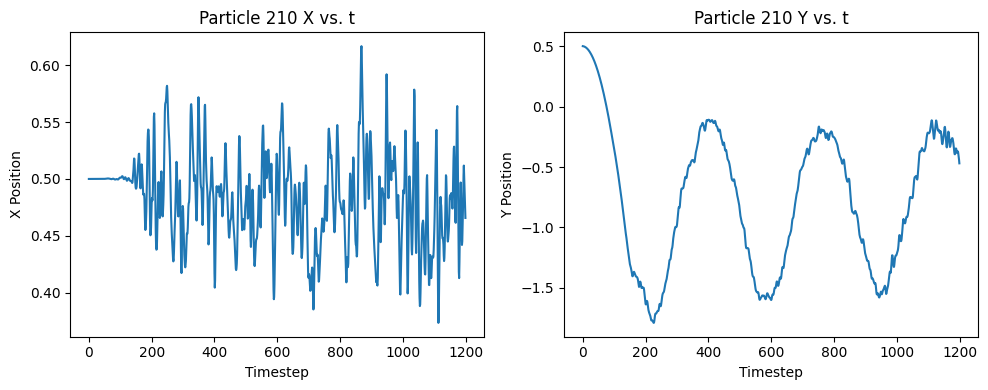

In [118]:
plot_at_index_vs_time(210, pos_test)

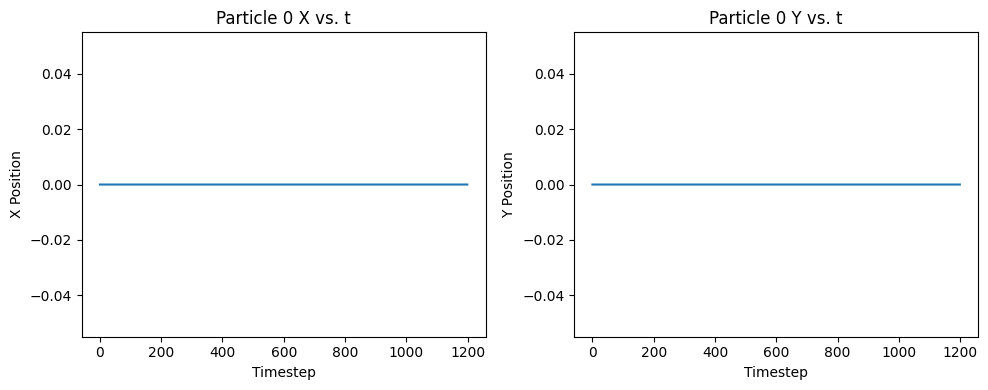

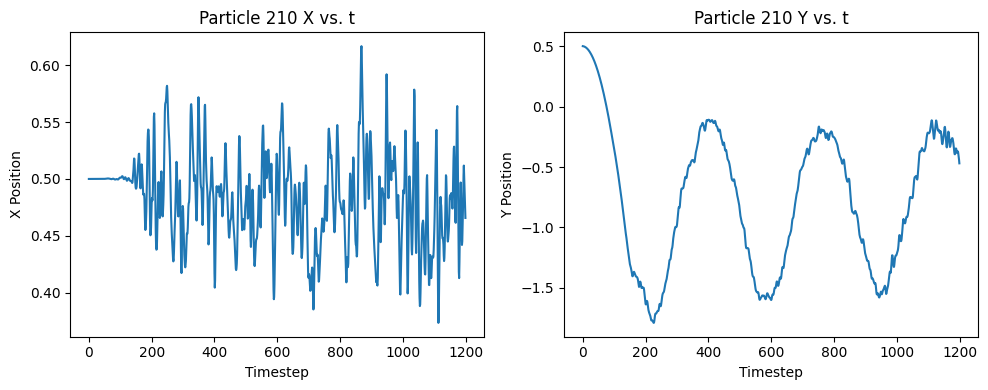

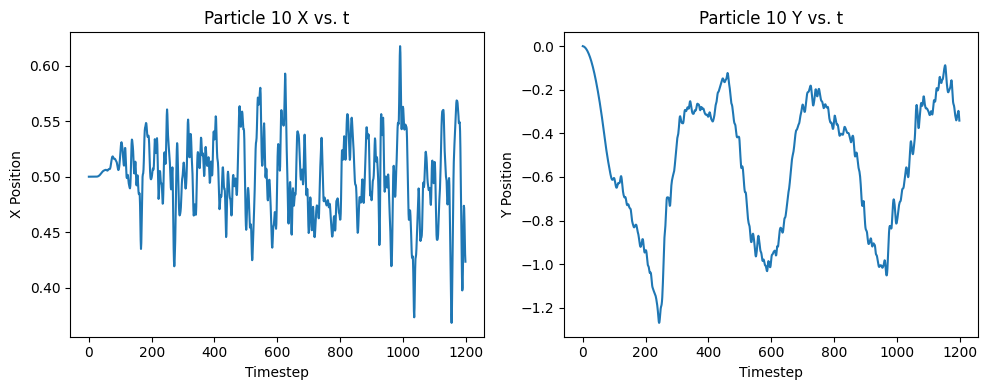

In [121]:
#keep in mind x is horizontal left to right direction, and 
plot_at_index_vs_time(0, pos_test)
plot_at_index_vs_time(210, pos_test)
plot_at_index_vs_time(10, pos_test)

0.25


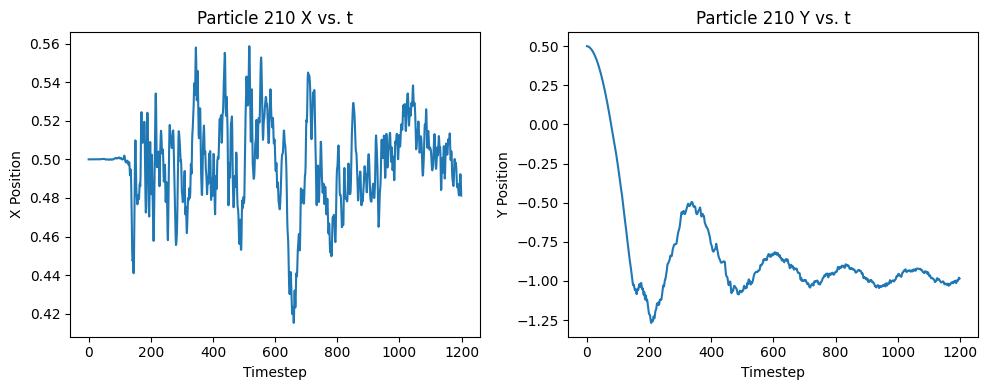

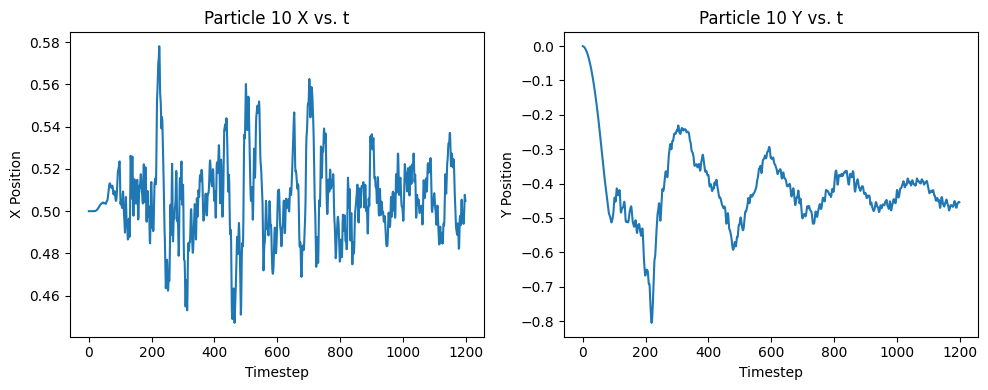

In [ ]:
# changing k and c
pos_1 = debug_sim(400.0, 0.01, 1.0/240.0, 9.81)
plot_at_index_vs_time(210, pos_1)
plot_at_index_vs_time(10, pos_1)

0.25
Module __main__ a13ce26 load on device 'cpu' took 483.23 ms  (compiled)


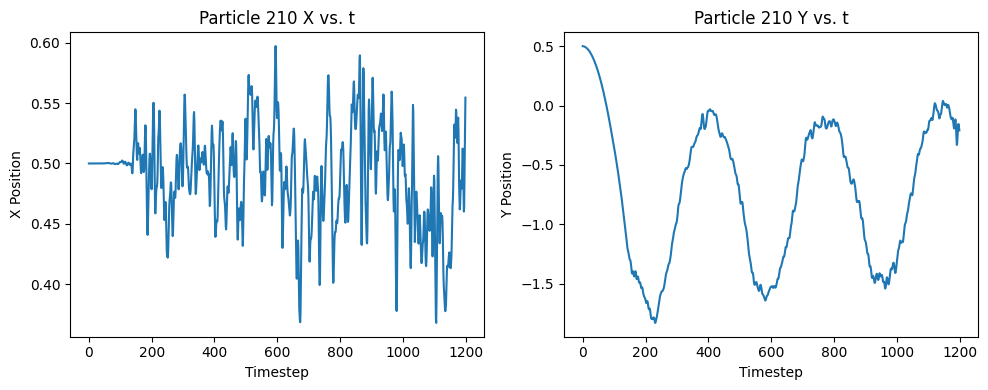

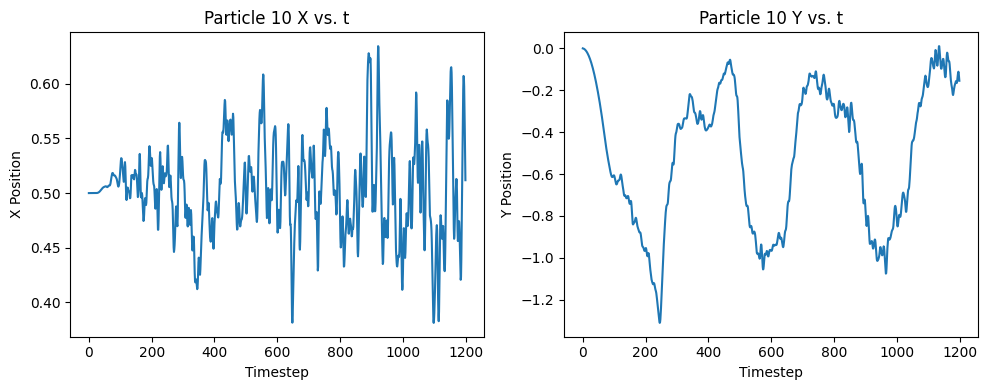

In [130]:
# no damping
pos_2 = debug_sim(200.0, 0.0, 1.0/240.0, 9.81)
plot_at_index_vs_time(210, pos_2)
plot_at_index_vs_time(10, pos_2)

These jitters are caused by how we are doing out integration, which can introduce jitters and also cause the energy to explore (how for particle 10 the amplitude increases here at later timesteps). Lets see if changing dt will fix this

0.25


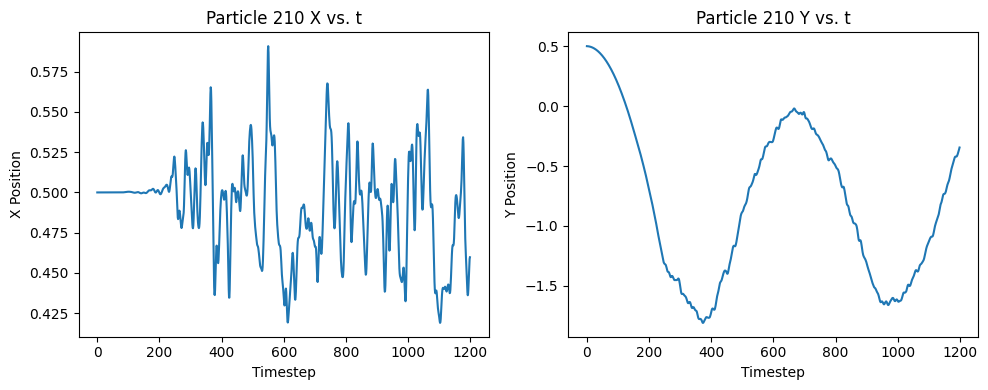

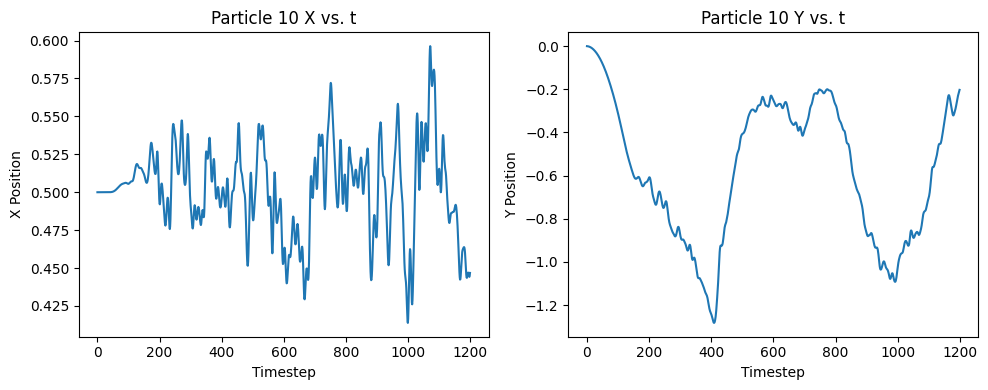

In [128]:
# reduce dt
pos_3 = debug_sim(200.0, 0.0, 1.0/400.0, 9.81)
plot_at_index_vs_time(210, pos_3)
plot_at_index_vs_time(10, pos_3)

generally, for stiffer springs, especially considering the ratio of stiffness to damping, we need higher dt. k/c ratio is also important. we can also try verlet integration